In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
sp500 = pd.read_csv("sp500_data_cleaned.csv", header=[0,1], index_col=0)

# extract returns
returns = sp500[('Log Returns', '^GSPC')]
returns = returns.sort_index()  # sort by date

# summary
print(returns.describe())


count    2515.000000
mean        0.000417
std         0.011270
min        -0.127652
25%        -0.003783
50%         0.000636
75%         0.005739
max         0.089683
Name: (Log Returns, ^GSPC), dtype: float64


#### Compute Rolling VaR for a 95% Confidence Level

In [2]:
# 250 rolling window
window = 250
# rolling 5th percentile (historical VaR) for each day where the window is available.
# (lower returns are worse; the quantile is negative; we report magnitude as positive loss later.)
rolling_VaR = returns.rolling(window=window).quantile(0.05)

#### Identify Exceptions (VaR Breaches)
For each day after the rolling window, an exception occurs when the actual return is less than the computed rolling VaR:

In [3]:
# compute if there is an exception.
# exception occurs when the actual return is below the VaR threshold.
exceptions = returns[window:] < rolling_VaR[window:]

# total number of exceptions and compute the exception rate.
exception_count = exceptions.sum()
total_test_days = len(returns[window:])
exception_rate = exception_count / total_test_days

print(f"Out of {total_test_days} test days, there were {exception_count} exceptions.")
print(f"Exception Rate: {exception_rate*100:.2f}%")

Out of 2265 test days, there were 114 exceptions.
Exception Rate: 5.03%


#### Plotting the Backtesting Results

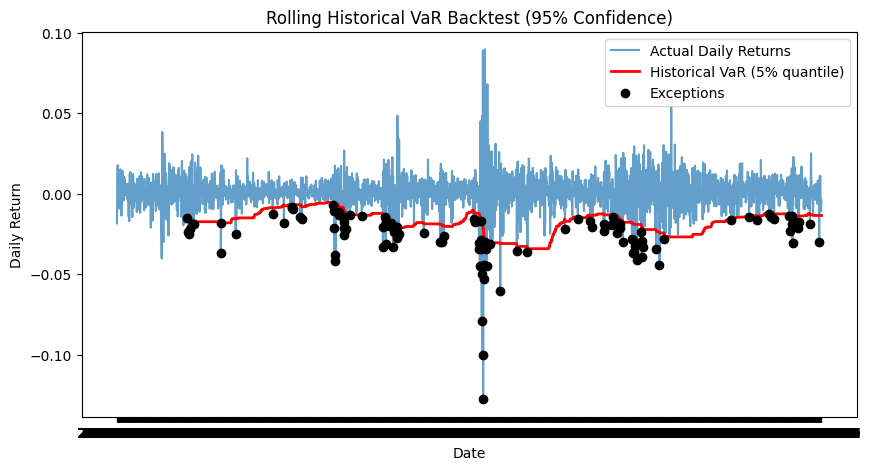

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns, label="Actual Daily Returns", alpha=0.7)
plt.plot(rolling_VaR.index, rolling_VaR, label="Historical VaR (5% quantile)", color="red", linewidth=2)

# mark exceptions on the plot
exception_dates = returns[window:][exceptions].index
plt.scatter(exception_dates, returns[window:][exceptions], color="black", label="Exceptions", zorder=5)

plt.title("Rolling Historical VaR Backtest (95% Confidence)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

#### Rolling Historic VaR:
250 day rolling window against a 2515 count dataset. We get 2265 test days. The code calculates the historical VaR from lets say day 1 to 250 and then evaluates if day 251's return exceeds the expected value. If the return exceeds, i.e: gives us a higher loss then what was calculated by the 250 day historical VaR, it is logged as an exception. For a set of 2265 test days, evaluated at a rate of 95%, the exceptions should be equal to or under 5% of 2265 which is 113.25. As shown in the code we have 114 exceptions with an exception rate of 5.03% which is not too out of the ordinary. Finally we plot these on a graph, from which we can see:
1. The exceptions mainly occur at periods of high volatility, in accordance with established literature. 
2. The relative responsiveness of the model(red line) to the actual daily returns (blue) indicate that 250 day rolling window is a good size. 

#### Bionmial tests

In [5]:
from scipy.stats import binomtest

# expected probability of an exception, p (0.05 for 95% VaR)
p_expected = 0.05

# a binomial test on the observed exception count
# n is total_test_days, and k is exception_count
test_result = binomtest(exception_count, total_test_days, p=p_expected, alternative='two-sided')

print("Kupiec Test Results:")
print("  Observed Exceptions:", exception_count)
print("  Total Test Days:", total_test_days)
print("  Expected Exceptions:", total_test_days * p_expected)
print("  p-value:", test_result.pvalue)


Kupiec Test Results:
  Observed Exceptions: 114
  Total Test Days: 2265
  Expected Exceptions: 113.25
  p-value: 0.9231823722365597


#### Testing different rolling window lengths

In [6]:
# Example: Testing two different window lengths
windows = [250, 500]
sensitivity_results = {}

for w in windows:
    rolling_VaR_w = returns.rolling(window=w).quantile(0.05)
    # Only test days with valid rolling VaR
    valid_returns = returns[w:]
    exceptions_w = valid_returns < rolling_VaR_w[w:]
    count_exceptions = exceptions_w.sum()
    total_days = len(valid_returns)
    rate = count_exceptions / total_days
    sensitivity_results[w] = (count_exceptions, total_days, rate)
    print(f"Window = {w} days: Exceptions = {count_exceptions}, Test Days = {total_days}, Rate = {rate*100:.2f}%")

Window = 250 days: Exceptions = 114, Test Days = 2265, Rate = 5.03%
Window = 500 days: Exceptions = 96, Test Days = 2015, Rate = 4.76%


#### Testing changing confidence levels

In [7]:
# Example: Testing different confidence levels
confidence_levels = [0.95, 0.99]
sensitivity_confidence = {}

for cl in confidence_levels:
    quantile_value = 1 - cl  # e.g., 0.05 for 95%, 0.01 for 99%
    rolling_VaR_cl = returns.rolling(window=window).quantile(quantile_value)
    valid_returns = returns[window:]
    exceptions_cl = valid_returns < rolling_VaR_cl[window:]
    count_exceptions_cl = exceptions_cl.sum()
    rate_cl = count_exceptions_cl / len(valid_returns)
    sensitivity_confidence[cl] = (count_exceptions_cl, rate_cl)
    print(f"Confidence Level = {int(cl*100)}%: Exceptions = {count_exceptions_cl}, Exception Rate = {rate_cl*100:.2f}%")


Confidence Level = 95%: Exceptions = 114, Exception Rate = 5.03%
Confidence Level = 99%: Exceptions = 33, Exception Rate = 1.46%


### Kupiec test:

Performing Kupiec test or POF test on the rolling historic VaR, we already know its a really good fit from our code earlier which gave it a exception rate of 5.03% on a 5% certainty. So we expect a high p value close to 1. And we get 0.92. 
Kupiec test is a variation on a binomial test. First Binomial tests: he most straightforward test is to compare the observed number of exceptions, _x_, to the expected number of exceptions. From the properties of a binomial distribution, you can build a confidence interval for the expected number of exceptions. Using exact probabilities from the binomial distribution or a normal approximation, the `bin` function uses a normal approximation.
Now Kupiec test builds on this, it uses a likelihood ratio to test whether the probability of exceptions is synchronized with the probability p implied by the VaR confidence level. 

### Week 7: Advanced Sensitivity Analysis, Model Refinement, and Consolidation of Findings

In [9]:
window_options = [250, 500, 750]
sensitivity_window = {}

for w in window_options:
    rolling_VaR_w = returns.rolling(window=w).quantile(0.05)
    valid_returns = returns[w:]
    exceptions_w = valid_returns < rolling_VaR_w[w:]
    count_exceptions = exceptions_w.sum()
    total_days = len(valid_returns)
    rate = count_exceptions / total_days
    sensitivity_window[w] = {
        'VaR': rolling_VaR_w,
        'Exceptions': count_exceptions,
        'Exception Rate': rate
    }
    print(f"Window = {w} days: Exceptions = {count_exceptions}, Rate = {rate*100:.2f}%")

Window = 250 days: Exceptions = 114, Rate = 5.03%
Window = 500 days: Exceptions = 96, Rate = 4.76%
Window = 750 days: Exceptions = 94, Rate = 5.33%


In [10]:
confidence_levels = [0.95, 0.99]
sensitivity_confidence = {}
window = 250  # Use a fixed window for this test

for cl in confidence_levels:
    quantile_value = 1 - cl  # e.g., 0.05 or 0.01
    rolling_VaR_cl = returns.rolling(window=window).quantile(quantile_value)
    valid_returns = returns[window:]
    exceptions_cl = valid_returns < rolling_VaR_cl[window:]
    count_exceptions_cl = exceptions_cl.sum()
    rate_cl = count_exceptions_cl / len(valid_returns)
    sensitivity_confidence[cl] = {
        'Rolling VaR': rolling_VaR_cl,
        'Exceptions': count_exceptions_cl,
        'Exception Rate': rate_cl
    }
    print(f"Confidence Level = {int(cl*100)}%: Exceptions = {count_exceptions_cl}, Rate = {rate_cl*100:.2f}%")

Confidence Level = 95%: Exceptions = 114, Rate = 5.03%
Confidence Level = 99%: Exceptions = 33, Rate = 1.46%


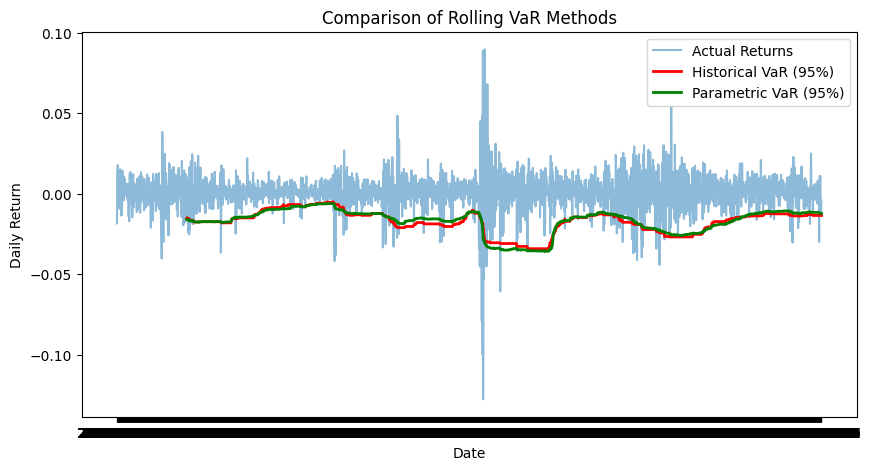

In [13]:
from scipy.stats import norm  # Add this line at the top

def rolling_parametric_VaR(returns, window, cl):
    # For a 5% left tail, z will be around -1.645
    alpha = 1 - cl   # e.g., 0.05 for cl=0.95
    z = norm.ppf(alpha)
    rolling_mu = returns.rolling(window=window).mean()
    rolling_sigma = returns.rolling(window=window).std()
    # Now this result will be negative if it's truly the 5% tail
    return rolling_mu + z * rolling_sigma

# Choose a window length (e.g., 250 days)
window = 250

# Rolling Historical VaR (as before)
rolling_VaR_hist = returns.rolling(window=window).quantile(0.05)
# Rolling Parametric VaR (for 95% confidence)
rolling_VaR_param = rolling_parametric_VaR(returns, window=window, cl=0.95)

plt.figure(figsize=(10,5))
plt.plot(returns.index, returns, label="Actual Returns", alpha=0.5)
plt.plot(rolling_VaR_hist.index, rolling_VaR_hist, label="Historical VaR (95%)", color='red', linewidth=2)
plt.plot(rolling_VaR_param.index, rolling_VaR_param, label="Parametric VaR (95%)", color='green', linewidth=2)
plt.title("Comparison of Rolling VaR Methods")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

Historical VaR (99%) Exceptions:
  Number of exceptions: 33
  Exception rate: 1.46%

Parametric VaR (99%) Exceptions:
  Number of exceptions: 63
  Exception rate: 2.78%



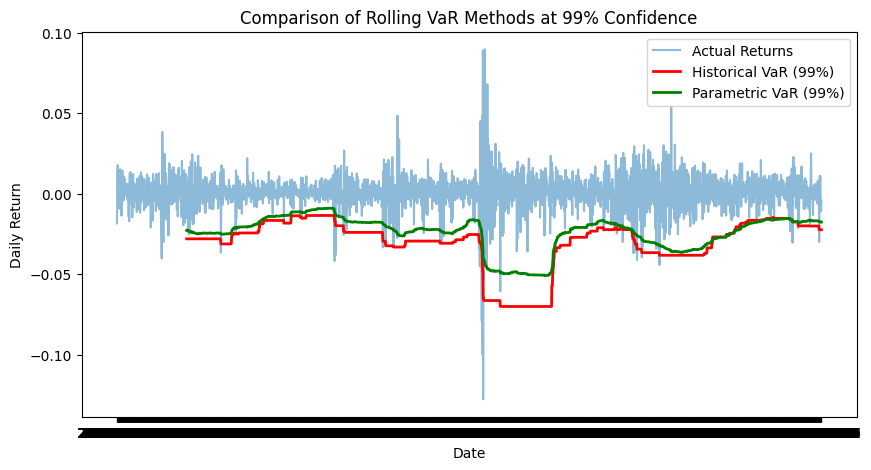

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume 'returns' is your daily returns series already loaded and indexed by date.
# For example:
# sp500 = pd.read_csv("sp500_data_cleaned.csv", header=[0,1], index_col=0)
# returns = sp500[('Log Returns','^GSPC')]
# returns = returns.sort_index()

# Set rolling window length (e.g., 250 trading days)
window = 250

# Compute Rolling Historical VaR at 99% confidence (i.e., 1% quantile)
rolling_VaR_hist_99 = returns.rolling(window=window).quantile(0.01)

# Define a function to compute rolling parametric VaR for a given confidence level
def rolling_parametric_VaR(returns, window, cl):
    # For 99% VaR, 1-cl = 0.01 so z will be around -2.33
    z = norm.ppf(1 - cl)
    rolling_mu = returns.rolling(window=window).mean()
    rolling_sigma = returns.rolling(window=window).std()
    # Return the left-tail cutoff directly (should be negative)
    return rolling_mu + z * rolling_sigma

# Compute Rolling Parametric VaR at 99% confidence using the same window
rolling_VaR_param_99 = rolling_parametric_VaR(returns, window=window, cl=0.99)

# Calculate Exceptions:
# Only consider days after the initial window period
test_returns = returns[window:]
exceptions_hist = test_returns < rolling_VaR_hist_99[window:]
exceptions_param = test_returns < rolling_VaR_param_99[window:]

# Count the exceptions and compute exception rates
exception_count_hist = exceptions_hist.sum()
exception_rate_hist = exception_count_hist / len(test_returns)
exception_count_param = exceptions_param.sum()
exception_rate_param = exception_count_param / len(test_returns)

# Print the results
print("Historical VaR (99%) Exceptions:")
print(f"  Number of exceptions: {exception_count_hist}")
print(f"  Exception rate: {exception_rate_hist*100:.2f}%\n")

print("Parametric VaR (99%) Exceptions:")
print(f"  Number of exceptions: {exception_count_param}")
print(f"  Exception rate: {exception_rate_param*100:.2f}%\n")

# Plot the results for comparison
plt.figure(figsize=(10,5))
plt.plot(returns.index, returns, label="Actual Returns", alpha=0.5)
plt.plot(rolling_VaR_hist_99.index, rolling_VaR_hist_99, label="Historical VaR (99%)", color='red', linewidth=2)
plt.plot(rolling_VaR_param_99.index, rolling_VaR_param_99, label="Parametric VaR (99%)", color='green', linewidth=2)
plt.title("Comparison of Rolling VaR Methods at 99% Confidence")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()